## Version 1 Similarity Search

Implemented by:
Anurag Rachcha, Gauri Verma and Shubham Mahajan for the course of Algorithmic Digital Marketing

In [2]:
#importing necesary libraries

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc

2.2.0


Loading all the images from the dataset that can be used for similarity search among themselves

Found [562] images


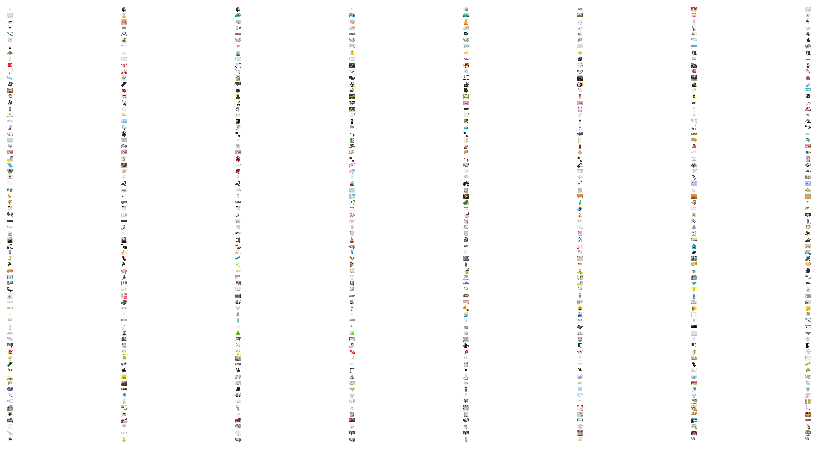

In [3]:
image_paths = glob.glob('C://Users//19293//Desktop//img//*.jpg')
print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image      

n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [4]:
image_path

'C://Users//19293//Desktop//img\\9905_1.jpg'

## Pre processing and modelling
Loading the images into a tensorflow and keras model 

In [5]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
  return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
  outputs = [baseline_model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # scale back the pixel values
    inputs = inputs*255.0
    # preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # pass through the reduced network
    outputs = self.vgg(preprocessed_input)
    # segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style

100%|██████████| 562/562 [10:11<00:00,  1.09s/it]


In [ ]:
#image_style_embeddings

Defining the function which takes input as a reference images and returns similar images based on the cosine distance computed.

In [6]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()

# images mostly match the reference style, although not perfectly
#search_by_style('9905_0.jpg')
# search_by_style('s_cubism-02.jpg')

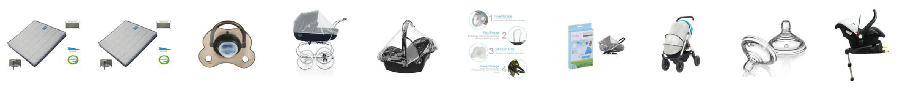

In [7]:
search_by_style('9905_0.jpg')

In [9]:
all_img = [a for a in images.keys()]

In [10]:
import pandas as pd
import numpy as np

In [11]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]
    #a.append(sorted_neighbors[:11])
    #return a
#     f, ax = plt.subplots(1, max_results, figsize=(16, 8))
#     for i, img in enumerate(sorted_neighbors[:max_results]):
#         ax[i].imshow(images[img[0]])
#         ax[i].set_axis_off()
    
#     plt.show()

Following steps are to create a csv of the images which can be used directly in streamlit for visual representation.

In [3]:
a = [search_by_style(image_name) for image_name in images.keys()]

NameError: name 'images' is not defined

In [ ]:
# all_img.to_csv("a.csv")

In [14]:
search_by_style("9905_0.jpg")

[('181781_0.jpg', 0.0),
 ('9905_0.jpg', 0.0),
 ('835212_3.jpg', 0.015015482902526855),
 ('1092339_0.jpg', 0.016518592834472656),
 ('1381037_2.jpg', 0.02124786376953125),
 ('835212_1.jpg', 0.021540462970733643),
 ('110899_0.jpg', 0.02357703447341919),
 ('2035896_0.jpg', 0.023663103580474854),
 ('1491382_0.jpg', 0.02418994903564453),
 ('684408_2.jpg', 0.025106728076934814),
 ('1062123_0.jpg', 0.02556443214416504)]

In [15]:
b = pd.DataFrame(a)
b

,0,1,2,3,4,5,6,7,8,9,10
0,"(1000699_0.jpg, 0.0)","(444101_3.jpg, 0.0035535097122192383)","(388175_0.jpg, 0.0036886930465698242)","(1631064_0.jpg, 0.003812253475189209)","(444101_2.jpg, 0.0040528178215026855)","(942620_1.jpg, 0.004470407962799072)","(388175_1.jpg, 0.004481971263885498)","(102427_0.jpg, 0.004567086696624756)","(1985202_0.jpg, 0.004935026168823242)","(634439_0.jpg, 0.004985392093658447)","(821201_0.jpg, 0.005173146724700928)"
1,"(101332_0.jpg, 0.0)","(101332_1.jpg, 0.0003209710121154785)","(1363998_0.jpg, 0.01701265573501587)","(144525_0.jpg, 0.0173456072807312)","(1601936_0.jpg, 0.018529415130615234)","(144525_2.jpg, 0.019147813320159912)","(1292390_0.jpg, 0.01975858211517334)","(144525_1.jpg, 0.02097463607788086)","(251394_3.jpg, 0.02240920066833496)","(1595808_2.jpg, 0.022439002990722656)","(2219063_3.jpg, 0.025252878665924072)"
2,"(101332_1.jpg, 0.0)","(101332_0.jpg, 0.0003209710121154785)","(144525_0.jpg, 0.017199993133544922)","(1363998_0.jpg, 0.01907283067703247)","(144525_2.jpg, 0.019678175449371338)","(1601936_0.jpg, 0.020679831504821777)","(144525_1.jpg, 0.02100992202758789)","(1292390_0.jpg, 0.022494196891784668)","(1595808_2.jpg, 0.023742258548736572)","(251394_3.jpg, 0.02426666021347046)","(1319162_0.jpg, 0.027621924877166748)"
3,"(102427_0.jpg, 0.0)","(1631064_0.jpg, 0.0010914206504821777)","(634439_0.jpg, 0.001626729965209961)","(388175_0.jpg, 0.0016500353813171387)","(388175_1.jpg, 0.0020821094512939453)","(821201_0.jpg, 0.0027813315391540527)","(1985202_0.jpg, 0.003065764904022217)","(2018843_0.jpg, 0.003425300121307373)","(1727476_0.jpg, 0.004079461097717285)","(839474_0.jpg, 0.00425189733505249)","(1000699_0.jpg, 0.004567086696624756)"
4,"(1024602_0.jpg, 0.0)","(1158718_0.jpg, 0.019083023071289062)","(1719926_1.jpg, 0.01926577091217041)","(971996_0.jpg, 0.021763920783996582)","(72326_1.jpg, 0.022426843643188477)","(43354_1.jpg, 0.023449063301086426)","(1199966_3.jpg, 0.02603989839553833)","(359078_0.jpg, 0.0285378098487854)","(1258869_0.jpg, 0.030359268188476562)","(328944_0.jpg, 0.035639166831970215)","(328944_1.jpg, 0.035639166831970215)"
...,...,...,...,...,...,...,...,...,...,...,...
557,"(971996_0.jpg, 0.0)","(1024602_0.jpg, 0.021763920783996582)","(1719926_1.jpg, 0.02527087926864624)","(72326_1.jpg, 0.026349782943725586)","(698597_0.jpg, 0.027803897857666016)","(2034696_1.jpg, 0.028234124183654785)","(805537_1.jpg, 0.028234124183654785)","(1582796_0.jpg, 0.03623014688491821)","(1833356_0.jpg, 0.03816521167755127)","(460054_0.jpg, 0.042861759662628174)","(328944_0.jpg, 0.0434916615486145)"
558,"(989685_0.jpg, 0.0)","(989685_1.jpg, 0.0)","(593186_0.jpg, 0.008347153663635254)","(127206_0.jpg, 0.008618950843811035)","(20730_3.jpg, 0.008642137050628662)","(1854940_0.jpg, 0.009187817573547363)","(2128367_0.jpg, 0.009390592575073242)","(444101_1.jpg, 0.00947493314743042)","(345278_0.jpg, 0.009673357009887695)","(1727003_0.jpg, 0.010696709156036377)","(49335_0.jpg, 0.010963499546051025)"
559,"(989685_0.jpg, 0.0)","(989685_1.jpg, 0.0)","(593186_0.jpg, 0.008347153663635254)","(127206_0.jpg, 0.008618950843811035)","(20730_3.jpg, 0.008642137050628662)","(1854940_0.jpg, 0.009187817573547363)","(2128367_0.jpg, 0.009390592575073242)","(444101_1.jpg, 0.00947493314743042)","(345278_0.jpg, 0.009673357009887695)","(1727003_0.jpg, 0.010696709156036377)","(49335_0.jpg, 0.010963499546051025)"
560,"(181781_0.jpg, 0.0)","(9905_0.jpg, 0.0)","(835212_3.jpg, 0.015015482902526855)","(1092339_0.jpg, 0.016518592834472656)","(1381037_2.jpg, 0.02124786376953125)","(835212_1.jpg, 0.021540462970733643)","(110899_0.jpg, 0.02357703447341919)","(2035896_0.jpg, 0.023663103580474854)","(1491382_0.jpg, 0.02418994903564453)","(684408_2.jpg, 0.025106728076934814)","(1062123_0.jpg, 0.02556443214416504)"


In [16]:
#Returns the first element of any list/tuple
def test(sorted_neighbour_tuple):
    return sorted_neighbour_tuple[0]

In [17]:
c = b.applymap(test)

In [18]:
c

,0,1,2,3,4,5,6,7,8,9,10
0,1000699_0.jpg,444101_3.jpg,388175_0.jpg,1631064_0.jpg,444101_2.jpg,942620_1.jpg,388175_1.jpg,102427_0.jpg,1985202_0.jpg,634439_0.jpg,821201_0.jpg
1,101332_0.jpg,101332_1.jpg,1363998_0.jpg,144525_0.jpg,1601936_0.jpg,144525_2.jpg,1292390_0.jpg,144525_1.jpg,251394_3.jpg,1595808_2.jpg,2219063_3.jpg
2,101332_1.jpg,101332_0.jpg,144525_0.jpg,1363998_0.jpg,144525_2.jpg,1601936_0.jpg,144525_1.jpg,1292390_0.jpg,1595808_2.jpg,251394_3.jpg,1319162_0.jpg
3,102427_0.jpg,1631064_0.jpg,634439_0.jpg,388175_0.jpg,388175_1.jpg,821201_0.jpg,1985202_0.jpg,2018843_0.jpg,1727476_0.jpg,839474_0.jpg,1000699_0.jpg
4,1024602_0.jpg,1158718_0.jpg,1719926_1.jpg,971996_0.jpg,72326_1.jpg,43354_1.jpg,1199966_3.jpg,359078_0.jpg,1258869_0.jpg,328944_0.jpg,328944_1.jpg
...,...,...,...,...,...,...,...,...,...,...,...
557,971996_0.jpg,1024602_0.jpg,1719926_1.jpg,72326_1.jpg,698597_0.jpg,2034696_1.jpg,805537_1.jpg,1582796_0.jpg,1833356_0.jpg,460054_0.jpg,328944_0.jpg
558,989685_0.jpg,989685_1.jpg,593186_0.jpg,127206_0.jpg,20730_3.jpg,1854940_0.jpg,2128367_0.jpg,444101_1.jpg,345278_0.jpg,1727003_0.jpg,49335_0.jpg
559,989685_0.jpg,989685_1.jpg,593186_0.jpg,127206_0.jpg,20730_3.jpg,1854940_0.jpg,2128367_0.jpg,444101_1.jpg,345278_0.jpg,1727003_0.jpg,49335_0.jpg
560,181781_0.jpg,9905_0.jpg,835212_3.jpg,1092339_0.jpg,1381037_2.jpg,835212_1.jpg,110899_0.jpg,2035896_0.jpg,1491382_0.jpg,684408_2.jpg,1062123_0.jpg


In [19]:
c.to_csv("algo1.csv")